In [56]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# Checking device
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(dev)

cuda


In [34]:
# Extracting files
from zipfile import ZipFile
fileName = "HW4.zip"

with ZipFile(fileName, 'r') as zip:
  zip.extractall()

In [35]:
# Resizing images as same size.
transformer = transforms.Compose([transforms.Resize((224, 224)),
                                  transforms.RandomHorizontalFlip(),# helps for succesful prediction.
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5, 0.5, 0.5], 
                                                       [0.5, 0.5, 0.5])
                                  ]) 

In [36]:
# Data loading

train_path = '/content/CaltechTinySplit/train'
test_path = '/content/CaltechTinySplit/test'

train_load = DataLoader(torchvision.datasets.ImageFolder(train_path, transform = transformer),
                        batch_size = 16, shuffle = True


)

test_load = DataLoader(torchvision.datasets.ImageFolder(test_path, transform = transformer),
                        batch_size = 16, shuffle = True


)

In [37]:
root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)
print(len(classes))

['Faces', 'Motorbikes', 'camera', 'cannon', 'cellphone', 'flamingo', 'hawksbill', 'ibis', 'pizza']
9


In [38]:
#CNN Network
class ConvNet(nn.Module): # Constructor of class.
  def __init__(self, num_classes = len(classes)):
    super(ConvNet, self).__init__()
    # formula of convulotion
    #o = (n + 2*p - f) / s + 1 # n: image height or width p: padding, f: filter size, s: stride
    # Conv1 layer input shape = (16, 3, 224, 224) // batchsize, number of channel(RGB), image size
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels=64, kernel_size = 3, stride = 1, padding = 1) #conv1

    # added
    self.bn1 = nn.BatchNorm2d(num_features = 64)
    # added
    # Conv2 layer input shape = (16, 64, 224, 224)
    self.conv2 = nn.Conv2d(in_channels = 64, out_channels=128, kernel_size = 6, stride = 2, padding = 0) #conv2
    # Swish activation input layer shape = (16, 128, 110, 110)
    self.swish1 = nn.SiLU()
    # Max pooling input layer shape = (16, 128, 110, 110)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    # Conv3 input layer shape = (16, 128, 55, 55)
    self.conv3 = nn.Conv2d(in_channels = 128, out_channels=256, kernel_size = 4, stride = 1, padding = 0)

    # added
    self.bn2 = nn.BatchNorm2d(num_features = 256)
    # added

    # Conv4 input layer shape = (16, 256, 52, 52)
    self.conv4 = nn.Conv2d(in_channels = 256, out_channels=512, kernel_size = 6, stride = 1, padding = 0)
    # ReLu input layer shape = (16, 512, 47, 47)
    self.relu1 = nn.ReLU()
    # Conv5 input layer shape = (16, 512, 47, 47)
    self.conv5 = nn.Conv2d(in_channels = 512, out_channels=1024, kernel_size = 4, stride = 3, padding = 1)
    self.bn3 = nn.BatchNorm2d(num_features = 1024)
    # Tanh input layer shape = (16, 1024, 16, 16)
    self.tanh1 = nn.Tanh()
    # Conv6 input layer shape = (16, 1024, 16, 16)
    self.conv6 = nn.Conv2d(in_channels = 1024, out_channels=2048, kernel_size = 3, stride = 3, padding = 1)
    # Swish activation input layer shape = (16, 2048, 6, 6)
    self.swish2 = nn.SiLU()

    self.fc1 = nn.Linear(in_features = 2048*6*6, out_features = 900)

    self.fc2 = nn.Linear(in_features = 900, out_features = num_classes)

  def forward(self, input):
    output = self.conv1(input)
    output = self.bn1(output)
    output = self.conv2(output)
    output = self.swish1(output)
    output = self.pool1(output)
    output = self.conv3(output)
    output = self.bn2(output)
    output = self.conv4(output)
    output = self.relu1(output)
    output = self.conv5(output)
    output = self.bn3(output)
    output = self.tanh1(output)
    output = self.conv6(output)
    output = self.swish2(output)

    output = output.view(-1, 2048*6*6)
    output = self.fc1(output)
    output = self.fc2(output)

    return output

In [39]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [40]:
model = ConvNet(num_classes = len(classes)).to(dev)

In [41]:
optimizer = Adam(model.parameters(), lr = 0.0001, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()

In [42]:
nofEpoch = 20

In [43]:
train_count = len(glob.glob(train_path+'/**/*.jpg'))
test_count = len(glob.glob(test_path+'/**/*.jpg'))
print(train_count)
print(test_count)

1346
174


In [46]:
def updateConfusionMatrix(confMat, nn_o, lbl, b_size):
  for i in range(b_size):
      confMat[lbl[i]][nn_o[i]] += 1
  return confMat

In [49]:
best_accuracy = 0.0
confMat = np.zeros((len(classes), len(classes)))
for epoch in range(nofEpoch):
  model.train()
  train_accuracy = 0.0
  train_loss = 0.0
  for i, (images,labels) in enumerate(train_load):
    if(torch.cuda.is_available()):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())
    optimizer.zero_grad()

    outputs = model(images) # gives the prediction

    dummy, indx = torch.max(outputs.data, 1)
    confMat = updateConfusionMatrix(confMat, indx, labels, indx.size(dim=0))
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.cpu().data*images.size(0)
    _, prediction = torch.max(outputs.data, 1)

    train_accuracy += int(torch.sum(prediction == labels.data))
  train_accuracy = train_accuracy/train_count
  train_loss = train_loss/train_count

  model.eval()
  test_accuracy = 0.0
  for i, (images,labels) in enumerate(test_load):
    if(torch.cuda.is_available()):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())
    outputs = model(images)
    _, prediction = torch.max(outputs.data, 1)
    test_accuracy += int(torch.sum(prediction == labels.data))
  test_accuracy = test_accuracy / test_count

  print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(int(train_loss)) + ' Train Accuracy: ' + str(train_accuracy) + ' Test Accuracy: ' + str(test_accuracy))
  if test_accuracy > best_accuracy:
    torch.save(model.state_dict(), 'best_checkpoint.mod')
    best_accuracy = test_accuracy

Epoch: 0 Train Loss: 0 Train Accuracy: 0.8848439821693908 Test Accuracy: 0.8218390804597702
Epoch: 1 Train Loss: 0 Train Accuracy: 0.8937592867756315 Test Accuracy: 0.8908045977011494
Epoch: 2 Train Loss: 0 Train Accuracy: 0.9197622585438335 Test Accuracy: 0.8793103448275862
Epoch: 3 Train Loss: 0 Train Accuracy: 0.937592867756315 Test Accuracy: 0.9137931034482759
Epoch: 4 Train Loss: 0 Train Accuracy: 0.9286775631500743 Test Accuracy: 0.9022988505747126
Epoch: 5 Train Loss: 0 Train Accuracy: 0.937592867756315 Test Accuracy: 0.8563218390804598
Epoch: 6 Train Loss: 0 Train Accuracy: 0.899702823179792 Test Accuracy: 0.7988505747126436
Epoch: 7 Train Loss: 0 Train Accuracy: 0.9294205052005944 Test Accuracy: 0.8620689655172413
Epoch: 8 Train Loss: 0 Train Accuracy: 0.9606240713224369 Test Accuracy: 0.8908045977011494
Epoch: 9 Train Loss: 0 Train Accuracy: 0.9665676077265973 Test Accuracy: 0.8620689655172413
Epoch: 10 Train Loss: 0 Train Accuracy: 0.9643387815750372 Test Accuracy: 0.9137931

In [76]:
# Loading validation data
valid_path = '/content/CaltechTinySplit/val'

valid_load = DataLoader(torchvision.datasets.ImageFolder(valid_path, transform = transformer),
                        batch_size = 16, shuffle = True)
valid_count = len(glob.glob(valid_path+'/**/*.jpg'))
print(valid_count)

165


In [77]:
# loading model and testing by validation data
modelNew = ConvNet(num_classes = len(classes)).to(dev)
modelNew.load_state_dict(torch.load('/content/best_checkpoint.mod'))
modelNew.eval()

valid_accuracy = 0.0
for i, (images,labels) in enumerate(valid_load):
  if(torch.cuda.is_available()):
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
  outputs = modelNew(images)
  _, prediction = torch.max(outputs.data, 1)
  valid_accuracy += int(torch.sum(prediction == labels.data))
valid_accuracy = valid_accuracy / valid_count
print('Validation Accuracy: ' + str(valid_accuracy))

Validation Accuracy: 0.8727272727272727


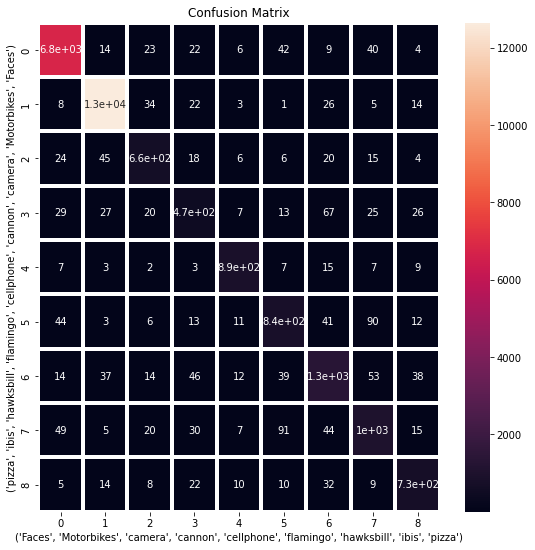

In [78]:
# Plotting confusion matrix
names = ("Faces", "Motorbikes", "camera", "cannon", "cellphone", "flamingo", "hawksbill", "ibis", "pizza")
plt.figure(figsize = (len(classes), len(classes)))
ax = sns.heatmap(confMat, linewidth=3, annot= True)
plt.xlabel(names)
plt.ylabel(tuple(reversed(names)))
plt.title('Confusion Matrix')
plt.show()